
# Imports

In [4]:
import os, sys, pickle, eli5
from tqdm import tqdm
import pandas as pd
pd.set_option('display.precision', 2)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from glob import glob
#from eli5.sklearn import PermutationImportance
sys.path.append(".")
sys.path.append("..")
from eli5.sklearn import PermutationImportance
#from rpy2.robjects.packages import importr
#from rpy2.robjects import r, pandas2ri
import dataframe_image as dfi
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Variables

In [5]:
projects = [
'shardingsphere-elasticjob','janusgraph','light-4j','inav','swagger-core','flatpak','RxJava','pygame','realm-java','glide','lxc','SoftEtherVPN','iceberg','netty','InfiniTime','mpv',
'zaproxy','premake-core','open5gs','netdata','presto','graylog2-server','mockito','AdAway','dynamorio','XChange','WinObjC','Terasology',
'FreeRDP','gatk','checkstyle','grpc-java','radare2','collectd','Mekanism','shenyu','klipper','lvgl','sway','samtools','libevent','druid','zfs','phpredis','hashcat',
'betaflight','spock','i3','PocketHub','framework','Rajawali','maxwell','pinpoint','nodemcu-firmware','nng','MinecraftForge','baritone','cleanflight','redis','jabref'
]

# Calculate feature importance

In [21]:
saved_model_info_list = []
# model_files = glob('/home/20cy3/topic1/clone2api/data/saved_models/20230912_*_RandomForestClassifier_0.5_0.5_0.5_*.pkl')
model_files = glob('../../data/clones/models/*_*_0.5_0.5_0.5_*.pkl')
model_files = [file for file in model_files if os.path.basename(file).split("_", 2)[1] in projects]
for model_file in model_files:
    project, classifier, lifecycle_threshold, prevalence_threshold, quality_threshold, auc = os.path.splitext(os.path.basename(model_file))[0].split('_')[1:7]
    classifier = classifier.replace("Classifier", "")
    threshold = '-'.join([lifecycle_threshold, prevalence_threshold, quality_threshold])
    saved_model_info = (project, classifier, threshold, auc)
    saved_model_info_list.append(saved_model_info)
saved_model_info_df = pd.DataFrame(saved_model_info_list, columns=['project', 'classifier', 'threshold', 'AUC'])  
saved_model_info_df['AUC_float'] = saved_model_info_df['AUC'].astype(float)
saved_model_info_df_filtered = saved_model_info_df.loc[saved_model_info_df.groupby(['project', 'threshold'])['AUC_float'].idxmax()]
print(saved_model_info_df_filtered.shape)


(60, 5)


In [11]:
feature_importance_df_all = []
for index, row in tqdm(saved_model_info_df_filtered.iterrows(), desc='get feature permutation importance'):
    project, classifier, threshold, auc = row['project'], row['classifier']+"Classifier", row['threshold'].replace("-", "_"), row['AUC']
    model_file_path = f'../../data/clones/models/{project}_{classifier}_{threshold}_{auc}.pkl'
    with open(model_file_path, 'rb') as fp:
        (grid_search_model, best_model_orig, x_train, y_train, x_test, y_test, auc_score_refit) = pickle.load(fp)

    if float(auc) < 0.7:
        continue
    else:
        best_model = grid_search_model.best_estimator_
        perm = PermutationImportance(best_model, random_state=1, scoring = 'roc_auc').fit(x_test, y_test)
        # eli5.show_weights(perm, feature_names = x_test.columns.tolist())
        
        #x = eli5.explain_weights(perm, feature_names = x_test.columns.tolist())
        feature_imp_df = eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names=x_test.columns.tolist()) #, top=5)
        feature_imp_df['project'] = project
        feature_importance_df_all.append(feature_imp_df)
    
feature_importance_df = pd.concat(feature_importance_df_all)
feature_importance_df = feature_importance_df[['project', 'feature', 'weight', 'std']]
feature_importance_df.to_csv('feature_importance_df.csv', index=False)

get feature permutation importance: 60it [00:22,  2.67it/s]


In [41]:
for feature in feature_importance_df['feature'].unique():
    feature_median, feature_mean = feature_importance_df[feature_importance_df['feature']==feature]['weight'].median(), feature_importance_df[feature_importance_df['feature']==feature]['weight'].mean()
    print(f'{feature:<25}', f'{feature_median:<25}', f'{feature_mean:<25}')

cnt_group_followers       0.060444024189536066      0.07249365476896888      
CountLineComment          0.002605437307923697      0.004453907004706768     
cnt_distinct_contributors 0.021928279299203282      0.04283513586436068      
path_jaccard_similarity   0.03992429997753706       0.05908428345779161      
CountLineBlank            0.0063313697869979094     0.016717918820643832     
CountLine                 0.0020450526224983665     0.008146912459287257     
CountInput                0.0028917304442186652     0.009934804979415264     
CountPath                 0.0011606484893146641     0.001552067552755268     
CountOutput               0.0022218498612722516     0.006260847673148225     
cnt_group_paras           0.006361736583058187      0.008682539824302017     
CountStmtDecl             0.002587775745670462      0.009902742322809905     
Essential                 0.0                       0.002921021158244646     


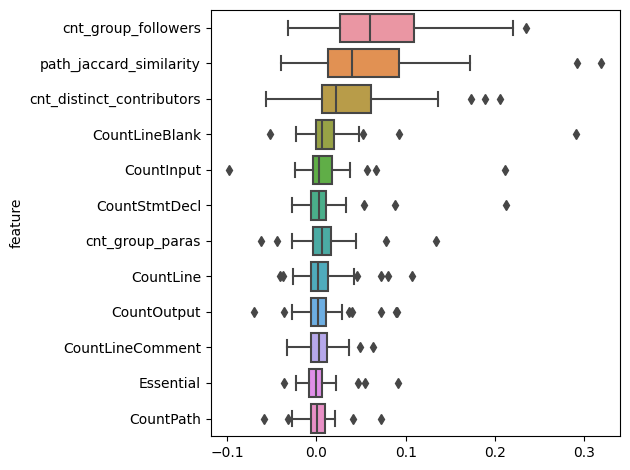

In [12]:
df2 = pd.pivot_table(feature_importance_df, values='weight',index='feature', columns='project')
# df2 = pd.pivot_table(df1, values='weight',index='project', columns='feature')
df2 = pd.pivot_table(feature_importance_df, values='weight',index='feature', columns='project')
df4 = df2.copy()
df4['weight_avg'] = df4.mean(axis=1)
df4['weight_var'] = df4.var(axis=1)
df5= df4.sort_values(by=['weight_avg'],ascending=False)
df6 = df5.iloc[:,0:-2]
df7 = df6.T
# fig = plt.figure(figsize=[6,4],dpi=300)
sns.boxplot(data=df7, orient='h')
plt.tight_layout()
plt.savefig('feature_weight_box.png',dpi=300)

# Check spearman

In [14]:

display(feature_importance_df.describe())
imp_median, imp_mean = feature_importance_df['weight'].median(), feature_importance_df['weight'].mean()
print(imp_median, imp_mean)


,weight,std
count,4.80e+02,4.80e+02
mean,2.02e-02,1.52e-02
std,4.93e-02,1.69e-02
min,-9.73e-02,0.00e+00
25%,-3.57e-03,5.09e-03
50%,5.76e-03,1.02e-02
75%,2.60e-02,1.89e-02
max,3.19e-01,1.19e-01


0.005756339438445302 0.020248819657202863


In [15]:
for feature in feature_importance_df['feature'].unique():
    feature_median, feature_mean = feature_importance_df[feature_importance_df['feature']==feature]['weight'].median(), feature_importance_df[feature_importance_df['feature']==feature]['weight'].mean()
    print(f'{feature:<25}', f'{feature_median:<25}', f'{feature_mean:<25}')

cnt_group_followers       0.060444024189536066      0.07249365476896888      
CountLineComment          0.002605437307923697      0.004453907004706768     
cnt_distinct_contributors 0.021928279299203282      0.04283513586436068      
path_jaccard_similarity   0.03992429997753706       0.05908428345779161      
CountLineBlank            0.0063313697869979094     0.016717918820643832     
CountLine                 0.0020450526224983665     0.008146912459287257     
CountInput                0.0028917304442186652     0.009934804979415264     
CountPath                 0.0011606484893146641     0.001552067552755268     
CountOutput               0.0022218498612722516     0.006260847673148225     
cnt_group_paras           0.006361736583058187      0.008682539824302017     
CountStmtDecl             0.002587775745670462      0.009902742322809905     
Essential                 0.0                       0.002921021158244646     


In [16]:
# res_threshold2 = res_threshold[res_threshold.weight >= 1.45e-01] # none
# res_threshold2 = res_threshold[res_threshold.weight <= 0.03393080649473011] # mean
feature_importance_df_filtered = feature_importance_df[feature_importance_df.weight >= imp_median] # median
# imp_threshold = feature_importance_df[feature_importance_df.weight >= imp_mean] # median
display(feature_importance_df_filtered['feature'].value_counts())

feature
cnt_group_followers          35
path_jaccard_similarity      31
cnt_distinct_contributors    30
CountLineBlank               20
cnt_group_paras              20
CountInput                   18
CountStmtDecl                17
CountLineComment             16
CountLine                    16
CountPath                    14
CountOutput                  12
Essential                    11
Name: count, dtype: int64

# Wilcoxin

## Check distribution with all the projects

In [25]:
all_project_df_list = []
acceptable_projects = feature_importance_df['project'].unique()
for project in acceptable_projects: # = 'checkstyle'
    reusable_clone_df = pd.read_csv(f"../../data/clones/dataset/{project}_raw_dataset_*_0.5_0.5_0.5.csv")
    all_project_df_list.append(reusable_clone_df)
    break
all_project_df = pd.concat(all_project_df_list)
print(all_project_df.shape)

(209, 49)


In [26]:
followers0 = list(all_project_df.loc[all_project_df.is_reusable==0]['cnt_group_followers'])
followers1 = list(all_project_df.loc[all_project_df.is_reusable==1]['cnt_group_followers'])

commonlen0 = list(all_project_df.loc[all_project_df.is_reusable==0]['len_common_path'])
commonlen1 = list(all_project_df.loc[all_project_df.is_reusable==1]['len_common_path'])

contributors0 = list(all_project_df.loc[all_project_df.is_reusable==0]['cnt_distinct_contributors'])
contributors1 = list(all_project_df.loc[all_project_df.is_reusable==1]['cnt_distinct_contributors'])

In [27]:
from scipy.stats import mannwhitneyu
print(mannwhitneyu(followers0, followers1))
print(mannwhitneyu(commonlen0, commonlen1))
print(mannwhitneyu(contributors0, contributors1))

MannwhitneyuResult(statistic=506.0, pvalue=0.0027382384459596573)
MannwhitneyuResult(statistic=951.0, pvalue=0.4680976562303182)
MannwhitneyuResult(statistic=537.0, pvalue=0.004320704484811575)


# Cliff's delta

In [30]:
followers0 = list(all_project_df.loc[all_project_df.is_reusable==0]['cnt_group_followers'])
followers1 = list(all_project_df.loc[all_project_df.is_reusable==1]['cnt_group_followers'])

commonlen0 = list(all_project_df.loc[all_project_df.is_reusable==0]['len_common_path'])
commonlen1 = list(all_project_df.loc[all_project_df.is_reusable==1]['len_common_path'])

contributors0 = list(all_project_df.loc[all_project_df.is_reusable==0]['cnt_distinct_contributors'])
contributors1 = list(all_project_df.loc[all_project_df.is_reusable==1]['cnt_distinct_contributors'])

In [32]:
# https://github.com/neilernst/cliffsDelta
from cliffs_delta import cliffs_delta

# hello world
'''
x1 = [10, 20, 20, 20, 30, 30, 30, 40, 50, 100]
x2 = [0, 10, 10, 10, 10, 10]
d, res = cliffs_delta(x1, x2)
print(d, res)
'''

d1, res1 = cliffs_delta(followers0, followers1)
print(d1, res1)

d2, res2 = cliffs_delta(commonlen0, commonlen1)
print(d2, res2)

d3, res3 = cliffs_delta(contributors0, contributors1)
print(d3, res3)
# -0.06666666666666667 negligible

0.13134905769984015 negligible
0.01917308200681914 negligible
0.01917308200681914 negligible


# Spearman Correlation

In [ ]:
from scipy.stats import spearmanr
projects_notacceptable = [os.path.basename(file).split("_", 2)[1] for file in low_auc_project_list]
acceptable_projects = feature_importance_df['project'].unique() # set(projects_all) - set(projects_notacceptable)
corr_list = []
for project in acceptable_projects:
    reusable_clone_path = f"../../data/clones/dataset/{project}_raw_dataset_*_0.5_0.5_0.5.csv"
    reusable_clone_df = pd.read_csv(reusable_clone_path)

    feature_cnt_group_followers = reusable_clone_df['cnt_group_followers']
    # feature_len_common_path = reusable_clone_df['len_common_path']
    feature_path_diversity = reusable_clone_df['path_jaccard_similarity']
    feature_cnt_distinct_contributors = reusable_clone_df['cnt_distinct_contributors']
    
    corr_followers = spearmanr(feature_cnt_group_followers, reusable_clone_df['is_reusable']).correlation
    corr_path = spearmanr(feature_path_diversity, reusable_clone_df['is_reusable']).correlation
    corr_contributors = spearmanr(feature_cnt_distinct_contributors, reusable_clone_df['is_reusable']).correlation
    
    corr_list.append([project, corr_followers, corr_path, corr_contributors])
    
corr_df = pd.DataFrame(corr_list, columns=['project', 'followers_corr', 'path_corr', 'contributors_corr'])


In [56]:
print(corr_df[corr_df['path_corr'] > 0].shape[0] / corr_df[corr_df['path_corr'] < 0].shape[0])
print(corr_df[corr_df['followers_corr'] > 0].shape[0] / corr_df[corr_df['followers_corr'] < 0].shape[0])
print(corr_df[corr_df['contributors_corr'] > 0].shape[0] / corr_df[corr_df['contributors_corr'] < 0].shape[0])

1.3529411764705883
1.8571428571428572
2.3333333333333335


In [102]:
corr_list = []
all_project_df_list = []
for project in acceptable_projects:
    reusable_clone_df = pd.read_csv(f'../../data/dataset/{project}_raw_dataset_0.5_0.5_0.5.csv')
    all_project_df_list.append(reusable_clone_df)

all_project_df = pd.concat(all_project_df_list)
spear_df = all_project_df[['cnt_group_followers', 'path_jaccard_similarity', 'cnt_distinct_contributors',  'CountLineComment', 'is_reusable']]
display(spear_df.corr(method='spearman'))

,cnt_group_followers,path_jaccard_similarity,cnt_distinct_contributors,CountLineComment,is_reusable
cnt_group_followers,1.00,-0.11,0.32,-0.06,-0.07
path_jaccard_similarity,-0.11,1.00,0.09,0.09,0.06
cnt_distinct_contributors,0.32,0.09,1.00,0.03,0.05
CountLineComment,-0.06,0.09,0.03,1.00,0.06
is_reusable,-0.07,0.06,0.05,0.06,1.00


In [101]:
display(spearmanr(spear_df, axis=0).correlation)

array([[ 1.        , -0.10814142,  0.3212197 , -0.06779989],
       [-0.10814142,  1.        ,  0.08658634,  0.05768435],
       [ 0.3212197 ,  0.08658634,  1.        ,  0.0549182 ],
       [-0.06779989,  0.05768435,  0.0549182 ,  1.        ]])